In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import wavfile
from scipy.signal import correlate, find_peaks
import sounddevice as sd
import wave
# matplotlib qt

# Microphone Parameters
1. Mic Gain: 80
2. Recording Mode: Ambisonics FuMa
3. Recording Format (Sampling Rate): 48kHz
4. Recording Format (Bit depth): 24-bit

In [66]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 4

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = 128

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [0, 0]
mic_positions[1, :] = [triangle_side, 0]
mic_positions[2, :] = [triangle_side / 2, (triangle_side * np.sqrt(3)) / 2]

# Functions to calculate the attenuation of different microphones

In [67]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    # Equation (3)
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    # Equation (4)
    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    # Component in equation (3)
    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    # Component in equation (4)
    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    # Equation (2)
    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, w_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, w_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))


In [68]:
from pydub import AudioSegment

def get_num_channels(wav_file_path):
    audio = AudioSegment.from_file(file=wav_file_path, format="wav")  
    num_channels = audio.channels
    return num_channels

# Function to plot four different waves
def plot_waves(time_axis, signal, title, xlabel='Time', ylabel='Amplitude'):
    # Extracting the channels
    w, x, y, z = extract_channels(signal)

    # Plotting the W componment
    plt.subplot(2, 2, 1)
    plt.plot(time_axis, w, color='blue')
    plt.title(f'{title} W component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the X component
    plt.subplot(2, 2, 2)
    plt.plot(time_axis, x, color='green')
    plt.title(f'{title} X component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Y component
    plt.subplot(2, 2, 3)
    plt.plot(time_axis, y, color='red')
    plt.title(f'{title} Y component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Plotting the Z component
    plt.subplot(2, 2, 4)
    plt.plot(time_axis, z, color='orange')
    plt.title(f'{title} Z component')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.tight_layout()
    plt.show()

# Loading the audio
We will plot the signals in its four channels (w, x, y, z) to analyze the data.

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_29203/614723687.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, mic1_signal = wavfile.read('../data/04_03/mic1.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_29203/614723687.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic2_signal = wavfile.read('../data/04_03/mic2.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_29203/614723687.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic3_signal = wavfile.read('../data/04_03/mic3.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_29203/614723687.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, gt_signal = wavfile.read('../data/04_03/gt.WAV')


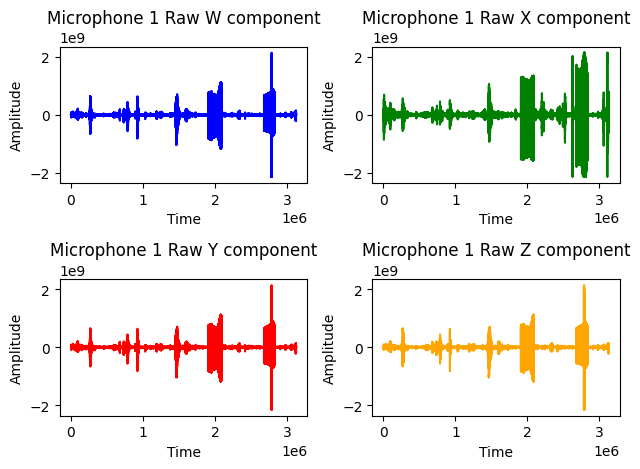

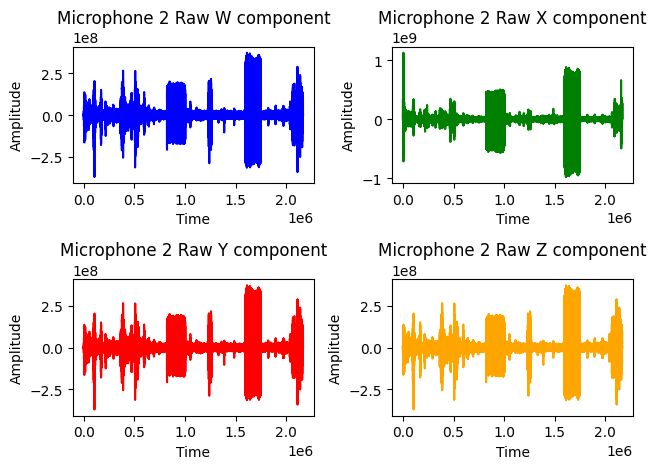

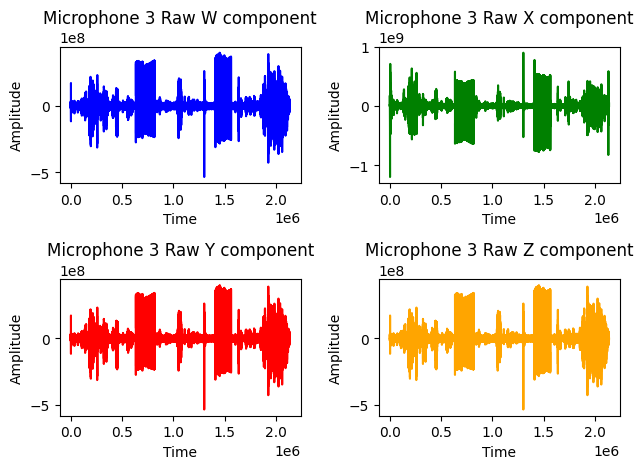

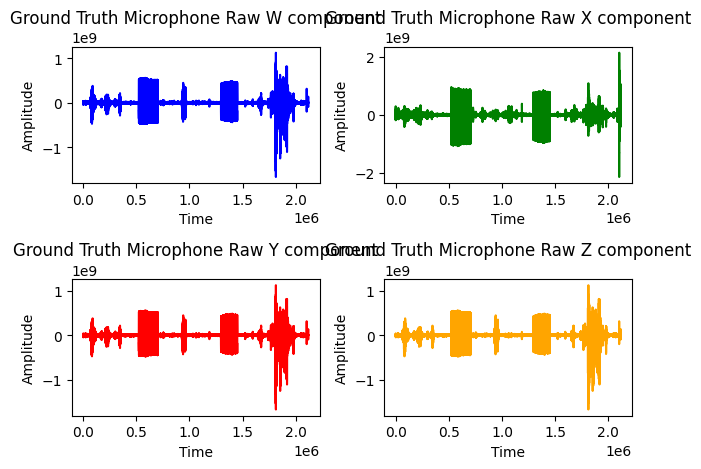

In [69]:
# Reading from the files
fs, mic1_signal = wavfile.read('../data/04_03/mic1.WAV')
_, mic2_signal = wavfile.read('../data/04_03/mic2.WAV')
_, mic3_signal = wavfile.read('../data/04_03/mic3.WAV')
_, gt_signal = wavfile.read('../data/04_03/gt.WAV')

# Original time_axes
time_1 = np.arange(1, mic1_signal.shape[0] + 1)
time_2 = np.arange(1, mic2_signal.shape[0] + 1)
time_3 = np.arange(1, mic3_signal.shape[0] + 1)
time_gt = np.arange(1, gt_signal.shape[0] + 1)

# Plotting the signals to check it out
plot_waves(time_1, mic1_signal, "Microphone 1 Raw")
plot_waves(time_2, mic2_signal, "Microphone 2 Raw")
plot_waves(time_3, mic3_signal, "Microphone 3 Raw")
plot_waves(time_gt, gt_signal, "Ground Truth Microphone Raw")


# Extracting the channels of the ambisonic microphone signals


In [70]:
# Extracting the data from each channel
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)
gt_w_signal, gt_x_signal, gt_y_signal, gt_z_signal = extract_channels(gt_signal)

# Synchonizing the data

We will use the following procedure to synchronize the recordings on the three microphones

1. Apply a Fourier Transform on the omni-directional signals of the data
2. Find the time at which the start and end A notes of the fourier transform are
3. Do a sanity check to make sure the length of time for all four of them are the same or around the same
4. If it's the same, make sure they're the same data. (Do some sort of correlation maybe? )

In [71]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import stft

def find_tone_start_end(signal, fs, target_freq=440, threshold=0.01, min_duration=5):
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / fs)

    # Identify the target frequency index
    target_index = np.argmin(np.abs(xf - target_freq))

    # Convert min_duration from seconds to the number of samples
    min_samples = min_duration * fs

    # Find where the magnitude exceeds the threshold
    magnitude = np.abs(yf)
    over_threshold = magnitude > (np.max(magnitude) * threshold)

    # Initialize start and end times
    t1, t2 = None, None

    # Iterate over the signal to find where the target frequency persists
    start_sample = None
    for i in range(N):
        if over_threshold[target_index]:
            if start_sample is None:
                print("Hello world")
                start_sample = i  # Starting index of the tone
        else:
            if start_sample is not None:
                print("Hello world")
                # Check if the duration meets the minimum requirement
                if (i - start_sample) >= min_samples:
                    t1 = start_sample / fs
                    t2 = i / fs
                    break  # Exit after finding the first tone of sufficient duration
                start_sample = None  # Reset start_sample for the next potential tone

    return t1, t2

    return spikes

def detect_440hz(filename):
    # Load audio file
    sample_rate, audio = wavfile.read(filename)
    if audio.ndim > 1:  # If stereo, take one channel
        audio = audio[:, 0]

    # Perform Short-Time Fourier Transform (STFT)
    f, t, Zxx = stft(audio, fs=sample_rate, nperseg=1024)

    # Find the frequency bin closest to 440 Hz
    target_freq_bin = np.argmin(np.abs(f - 440))

    # Detect segments where 440 Hz has significant energy
    threshold = np.max(np.abs(Zxx[target_freq_bin])) * 0.8  # 80% of max as an example threshold
    detected_times = t[np.abs(Zxx[target_freq_bin]) > threshold]

    # Convert time to sample indices
    detected_indices = (detected_times * sample_rate).astype(int)

    return detected_indices
# Function to plot the fourier transform
def plot_fourier_transform(signal, fs):
    """
    Plots the Fourier Transform of a given signal.

    Args:
        signal: The input signal (time-domain).
        fs: The sampling rate (in Hz).
    """
    # Compute the Fourier Transform
    N = len(signal)
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1/fs)

    # Only plot the positive frequencies
    mask = xf > 0

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(xf[mask], 2.0/N * np.abs(yf[mask]))
    plt.title("Fourier Transform")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid()
    plt.show()

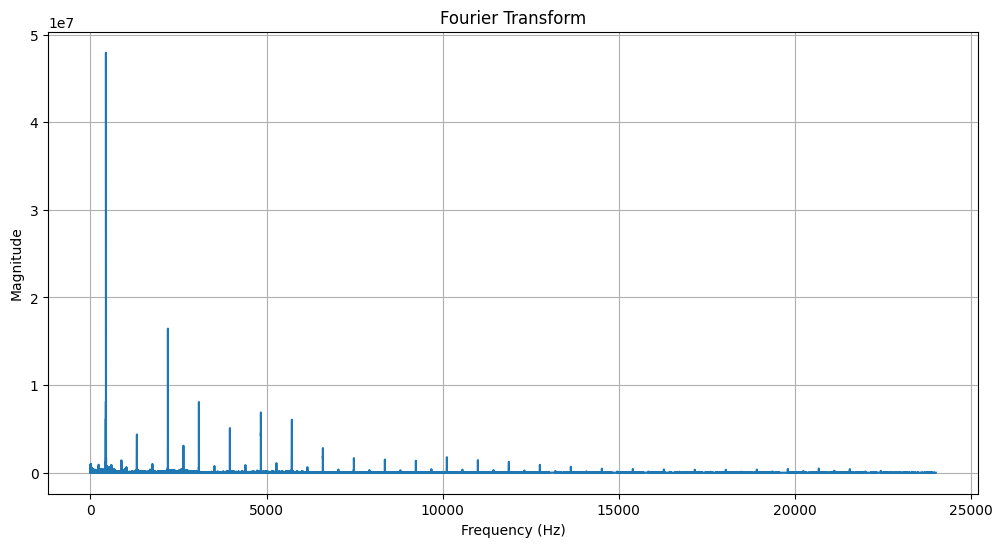

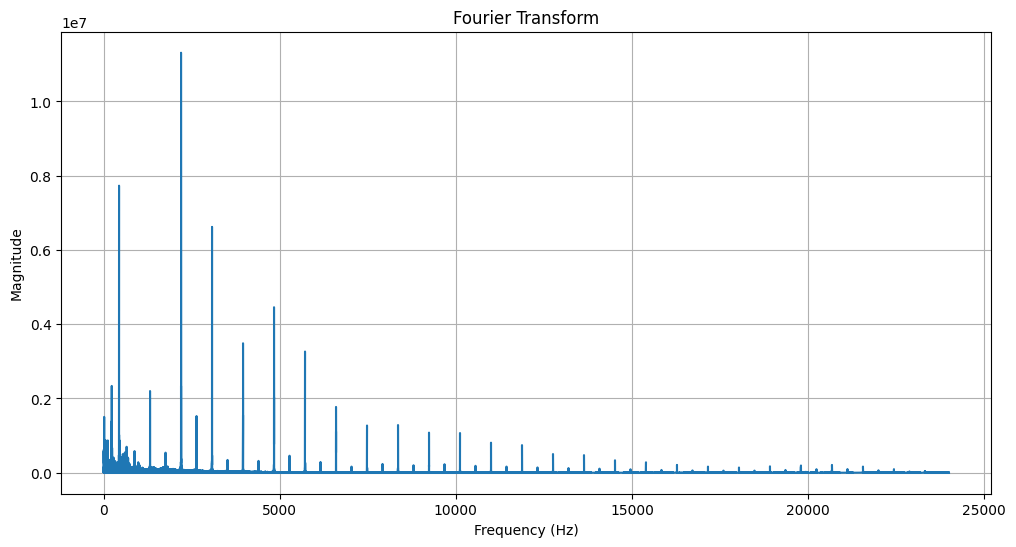

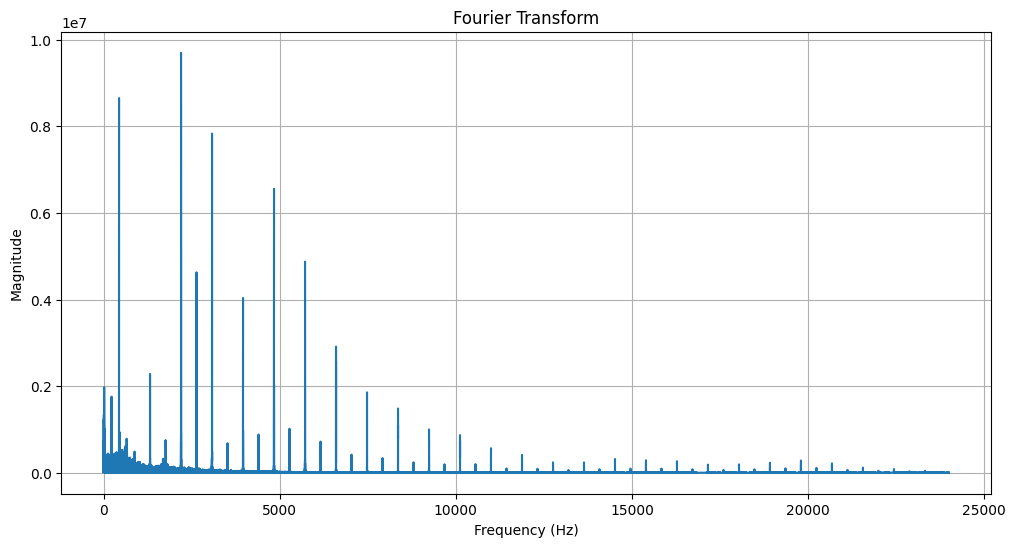

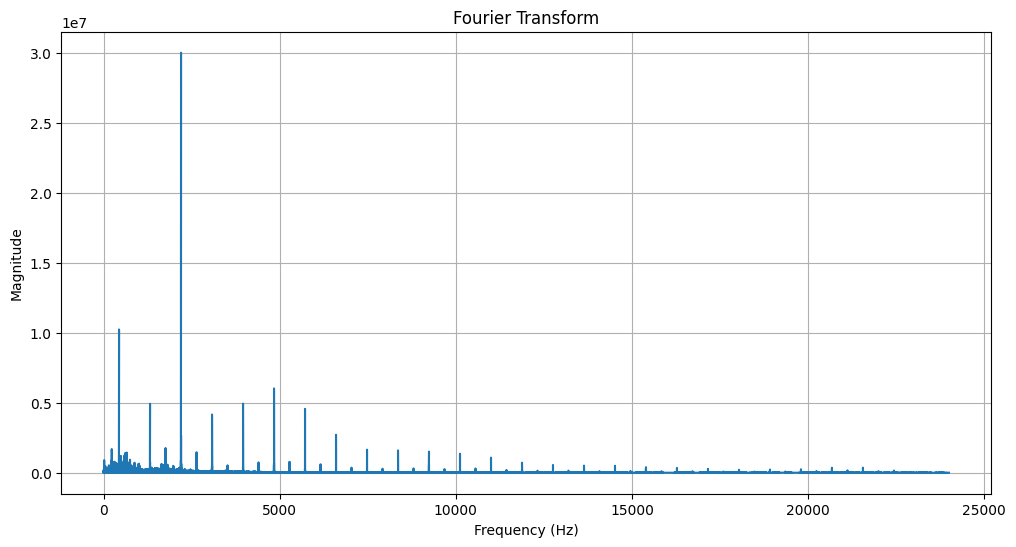

In [72]:
# Plotting the fourier transforms of the omnidirectional signals
plot_fourier_transform(mic1_w_signal, fs)
plot_fourier_transform(mic2_w_signal, fs)
plot_fourier_transform(mic3_w_signal, fs)
plot_fourier_transform(gt_w_signal, fs)


In [81]:
import librosa

def detect_pitch_yin(audio, sr):
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    return pitches, magnitudes

# Detect pitch
pitches, magnitudes = detect_pitch_yin(mic1_w_signal, fs)
print(pitches, magnitudes)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
